In [9]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,10)})

*If you are viewing this via GitHub - aplogies for the alignment issues for the equations - this is an issue with github's notebook rendering which I have reported to them.*

### Generate some data

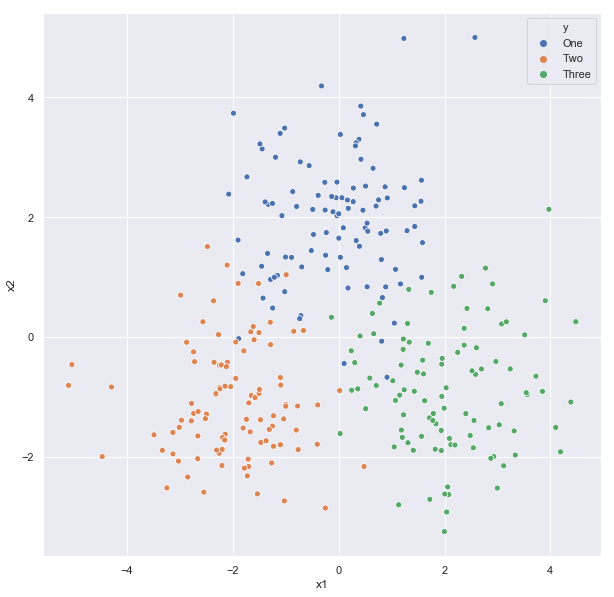

In [10]:
# 3 classes, normally distributed with reasonable separation
class_1 = np.random.normal([0, 2], 1, (100, 2))
class_2 = np.random.normal([-2, -1], 1, (100, 2))
class_3 = np.random.normal([2, -1], 1, (100, 2))
X = np.vstack([class_1, class_2, class_3])

# label the classes
labelled_class_1 = np.hstack([class_1, np.repeat(1, 100).reshape(-1,1)])
labelled_class_2 = np.hstack([class_2, np.repeat(2, 100).reshape(-1,1)])
labelled_class_3 = np.hstack([class_3, np.repeat(3, 100).reshape(-1,1)])

# combine into a dataframe
labelled_X = np.vstack([labelled_class_1, labelled_class_2, labelled_class_3])
X_df = pd.DataFrame(labelled_X, columns=['x1', 'x2', 'y'])

# plot
scatter_df = X_df.copy()
scatter_df['y'] = scatter_df['y'].map({1 : 'One', 2: 'Two', 3: 'Three'})
sns.scatterplot(x='x1', y='x2', hue='y', data=scatter_df)

### Model

We will assume the class conditional density of $X$ is given by the multivariate gaussian $f_k(x)$ where each class:
- Has a specific mean
- *Shares* a covariance matrix with the other classes


$f_k(x) = \frac{1}{(2 \pi)^{p/2}|\sum|^{1/2}} e^{-\frac{1}{2}(x - \mu_k)^T \sum^{-1}(x - \mu_k)}$


Combined with a prior: $\pi_k$, we can use Bayes theorem to assign a proability of class membership for each class given some observation $x$:

$Pr(G = k | X = x) = \frac{f_k(x)\pi_k}{\sum_{\ell = 1}^K f_{\ell}(x) \pi_{\ell}}$

We will use the training data to compute **estimates** for the prior $\pi_k$ and covariance matrix $\sum$ and plug them into the above, to yield a prediction.

### Computing Estimates

Our estimate for $\pi_k$ will be the fraction of observations belonging to class $k$ in the training set:

$\frac{N_k}{N}$

In [29]:
def estimate_pi_k(X, class_indeces):
    return [X[idx_list].shape[0] / X.shape[0] for idx_list in class_indeces]

Our estimate for $\mu_k$ will be the class specific mean for each predictor: 

$\sum_{y_i=k} \frac{x_i}{N_k}$

In [38]:
def estimate_mu(X, class_indeces):
    return [X[idx_list].mean(axis=0).reshape(-1,1) for idx_list in class_indeces]

Our estimate for $\sum$ will be the weighted average of the class specific covariance matrices:

$\sum_{k=1}^K \sum_{y_i=k} \frac{(x_i - \mu_k)(x_i - \mu_k)^T}{N - K}$

*read more about [pooled variance](https://en.wikipedia.org/wiki/Pooled_variance)*

In [50]:
def estimate_sigma(X, class_indeces):
    # Pooled variance note: https://en.wikipedia.org/wiki/Pooled_variance
    sigma = np.zeros((X.shape[1], X.shape[1]))
    for idx_list in class_indeces:
        Xc = X[idx_list]
        # equivalent to np.cov(Xc, rowvar=False, ddof=0) * N
        cov = (Xc - Xc.mean(axis=0)).T @ (Xc - Xc.mean(axis=0))
        sigma = sigma + cov / (X.shape[0] - Xc.shape[0])
    return sigma

The 

One [can show](https://raw.githubusercontent.com/coxy1989/mlsabbatical/master/notebooks/statistical_learning/ch4_statistical_learning/Q2.jpeg) that assigning the class for which maximises the probability given by the Bayes formulation is equivalent to assigning the class which maximises the *discriminant function*:

$\delta(x) = x^T \sum^{-1} \mu_k - \frac{1}{2} \mu_k^T \sum^{-1}\mu_k + log(\pi_k)$

In [43]:
def discriminant(sigma, X, mu, pi):
    sig_inv = np.linalg.inv(sigma)
    # I'm computing the three operands seperately for readability
    opr1 = X @ sig_inv @ mu 
    opr2 = (mu.T @ sig_inv @ mu)/2
    opr3 = np.log(pi)
    return opr1 - opr2 + opr3

In [44]:
# Fit the model for the example data
class_indeces = [X_df.y == v for v in X_df.y.unique()]
sig = estimate_sigma(X, class_indeces)
pi = estimate_pi_k(X, class_indeces)
mu = estimate_mu(X, class_indeces)

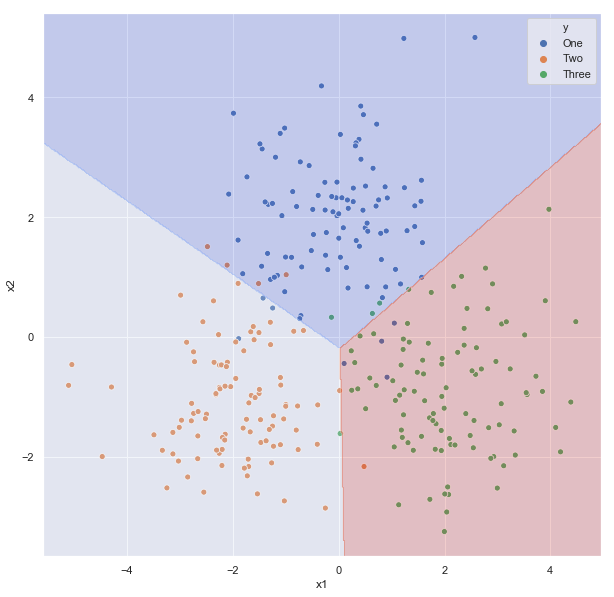

In [49]:
# plot the example data, obtain a range of (x,y)'s to superimpose a contour plot
ax = sns.scatterplot(x='x1', y='x2', hue='y', data=scatter_df)
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
xx1 = np.linspace(x_min, x_max, 500)
xx2 = np.linspace(y_min, y_max, 500)
xx1, xx2 = np.meshgrid(xx1, xx2)

# calculate discriminants
grid_X = np.vstack([xx1.ravel(), xx2.ravel()]).T
d1 = discriminant(sig, grid_X, mu[0], pi[0])
d2 = discriminant(sig, grid_X, mu[1], pi[1])
d3 = discriminant(sig, grid_X, mu[2], pi[2])

# plot the decision boundry
preds = np.argmax(np.hstack([d1,d2,d3]), axis=1) + 1
plt.contourf(xx1, xx2, preds.reshape(xx1.shape), alpha=0.25, cmap='coolwarm')

In [ ]:
# TODO 
# - 3 contour plots: one for proablilty of each class
# - DOF subtraction to make an estimator unbiased - https://stats.stackexchange.com/questions/90615/estimating-the-covariance-matrix-in-linear-discriminant-analysis